Note book to assess precipitation efficiency in Rosi's MPAS aquaplanet simulations

### Main settings

In [156]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
from scipy import stats
import numpy as np

In [157]:
data_path = '/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out/'
# data_path = '../../../pickle_out/aquaplanet/'
test_names = ["CTL","HOMO_RAD","CLIM_RAD"]
ntest = len(test_names)
pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
pclass_names_long = ['DeepC', 'Congest', 'Shallow', 'Stratiform', 'Anvil', 'DSA']
# pclass_names=["Deep", "Congestus", "Shallow", "Stratiform", "Anvil"]#, "DSA"] # DSA isn't there yet
nclass = len(pclass_names)

### Read data

In [158]:
# Get list of files
def get_file_list():
    # Get list of desired file times
    file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00',
                               6, dtype='datetime64[h]')
    file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]
    ntime = len(file_times)
    times = np.arange(ntime)/4 #+ 1.25
    return file_times, times

file_times, times = get_file_list()
ntime = len(times)

In [159]:
dims = (ntest, nclass, ntime)
pclass_area = np.full(dims, np.nan)
mu = np.full(dims, np.nan)
md = np.full(dims, np.nan)

for iexp in range(ntest):
    for it, time in enumerate(file_times):
        pickle_file = data_path+'VMF_pclass_'+test_names[iexp]+'_'+time+'.pickle'
        try:
            with open(pickle_file, 'rb') as f:
                file = pickle.load(f)
            for iname in pclass_names:
                # mu[expName][iname] = []
                # Read in variables from pickle
                # for iclass in range(nclass):
                pclass_area[iexp,:,it] = file[0]
                mu[iexp,:,it] = file[1]
                md[iexp,:,it] = file[2]
        except:
            pass

# for iclass in range(nclass):
#     # print(pclass_names[iclass], np.mean(pclass_area[0,iclass,:]))
#     # print(pclass_names[iclass], np.mean(mu[0,iclass,:]))
#     print(pclass_names[iclass], mu[0,iclass,-1])

In [160]:
file[1][:]
mu[0,3,:]

array([1104.11914062, 1076.00537109,  558.2331543 ,  336.06991577,
        309.04650879,  335.08563232,  255.32148743,  209.87414551,
        198.74473572,  209.02481079,  242.95593262,  206.3057251 ,
        202.96356201,  169.40080261,  191.20378113,  110.52627563,
        118.80467224,  115.41729736,  144.81439209,  146.81239319,
        136.51960754,  143.00949097,  160.55111694,  193.72596741,
        141.15910339,  128.39840698,  152.58840942,  105.02474976,
         93.67254639,   79.56412506,   86.98781586,  102.03907013,
         84.54524231,   91.2215271 ,  115.23451996,  156.49491882,
        175.06355286,  158.56636047,  200.89796448,  134.52639771])

#### PClass fraction

In [161]:
# For latbounds: 0, 10.0
# 5628214 grid cells
# For latbounds: 15, 20.0
# 2697020 grid cells

tot_cellcount = 2697020
tot_area = np.sum(pclass_area, axis=1)
pclass_frac = np.copy(pclass_area)
for iclass in range(nclass):
    # pclass_frac1[:,iclass,:] = 1e2*pclass_area[:,iclass,:] / tot_area
    pclass_frac[:,iclass,:] = 1e2*pclass_area[:,iclass,:] / tot_cellcount
    # print(pclass_names[iclass],
    #       np.mean(pclass_area[0,iclass,:]),
    #       np.mean(pclass_frac1[0,iclass,:]),
    #       np.mean(pclass_frac2[0,iclass,:]))

### Plotting

#### Time series

In [162]:
# Function to compute running mean
def running_mean_conf(time_series):
    nd_smooth    = 6 # days
    nd_window_ci = 6
    # nd_smooth    = 20 # days
    # nd_window_ci = 20
    ntpday = 4 # timesteps per day
    window_size = nd_smooth*ntpday  # Adjust as needed
    window_size_ci = nd_window_ci*ntpday  # Adjust as needed
    tser_smooth = np.convolve(time_series, np.ones(window_size) / window_size, mode='valid')
    tser_ci = np.convolve(time_series, np.ones(window_size_ci) / window_size_ci, mode='valid')
    # Compute standard error of the mean
    standard_error = stats.sem(time_series)  # Standard error of the original data
    z_score = 1.96 # Z-score for 95% confidence interval
    confidence_interval = z_score * standard_error  # 95% confidence interval
    # confidence_interval = np.zeros_like(tser_ci)
    # # for i in range(len(tser_smooth)):
    # for i in range(len(tser_ci)):
    #     subset = time_series[i:i+window_size_ci]
    #     standard_error = stats.sem(subset)
    #     confidence_interval[i] = z_score * standard_error
    #     # Q1 = np.percentile(subset, 25)
    #     # Q3 = np.percentile(subset, 75)
    #     # IQR = Q3 - Q1
    #     # confidence_interval[i] = IQR/2
    return tser_smooth, confidence_interval, window_size, tser_ci, window_size_ci

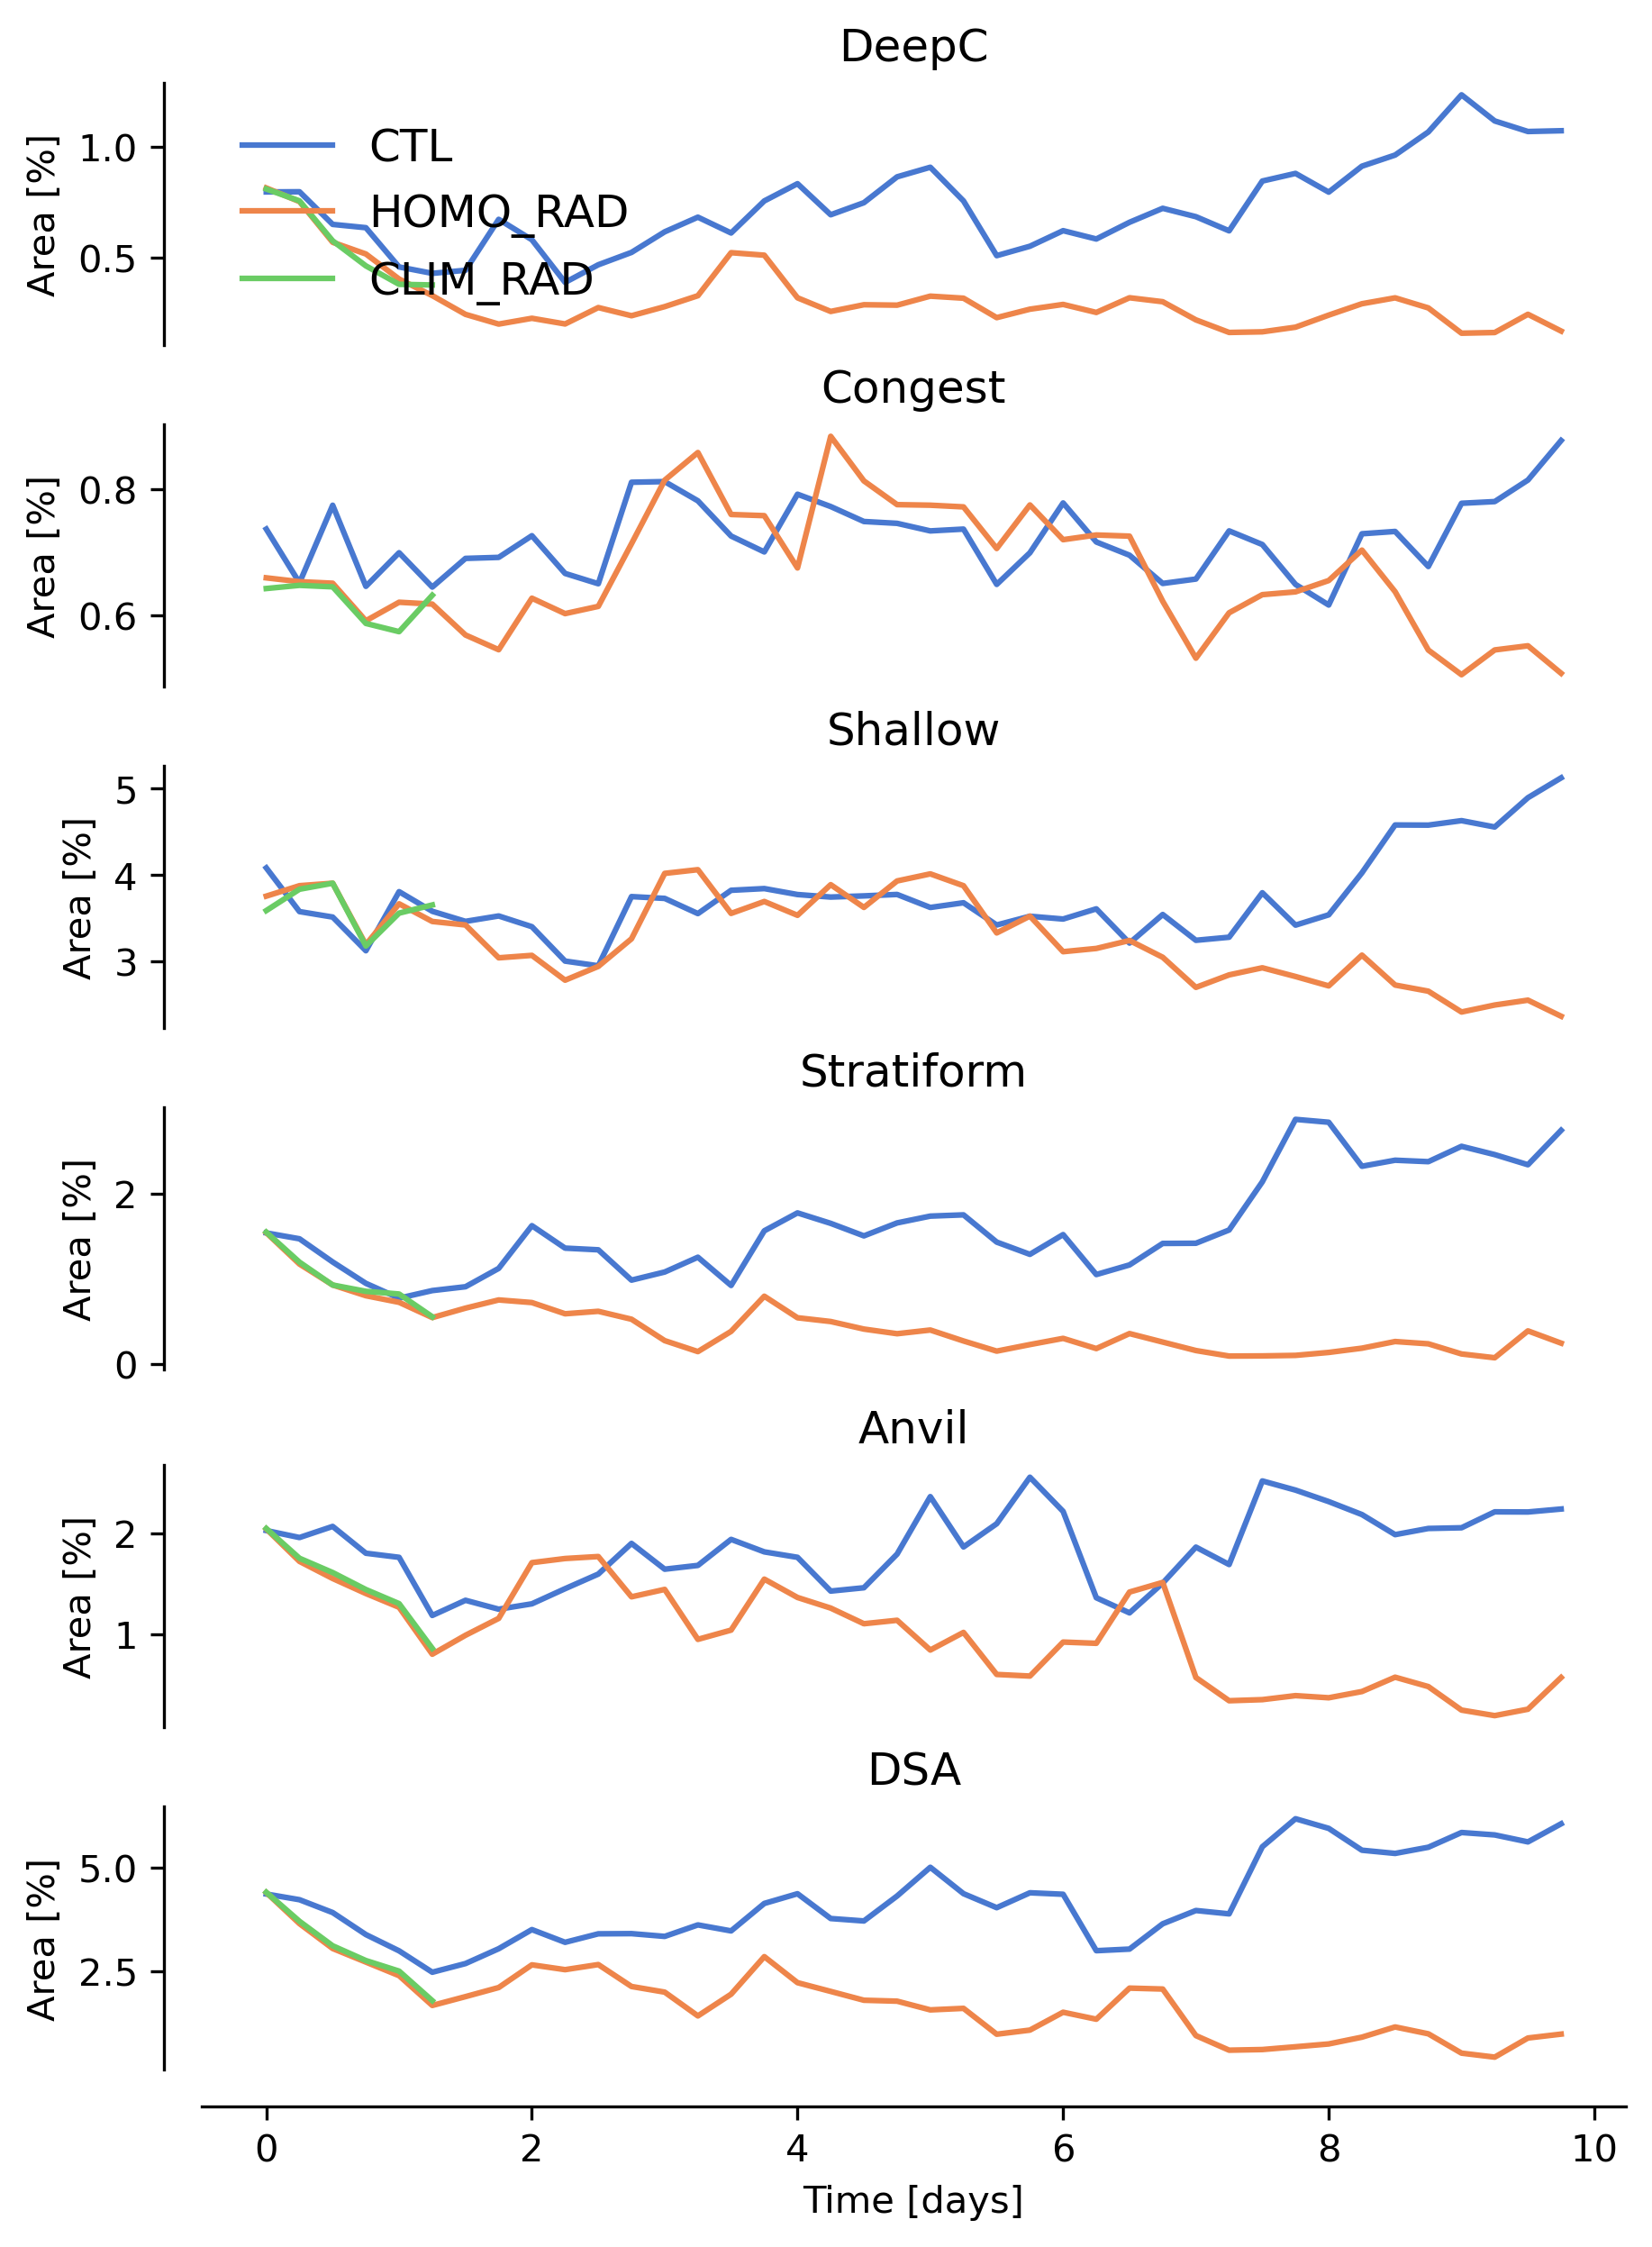

In [163]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('Area [%]')

    for iexp in range(ntest):
        tser = pclass_frac[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

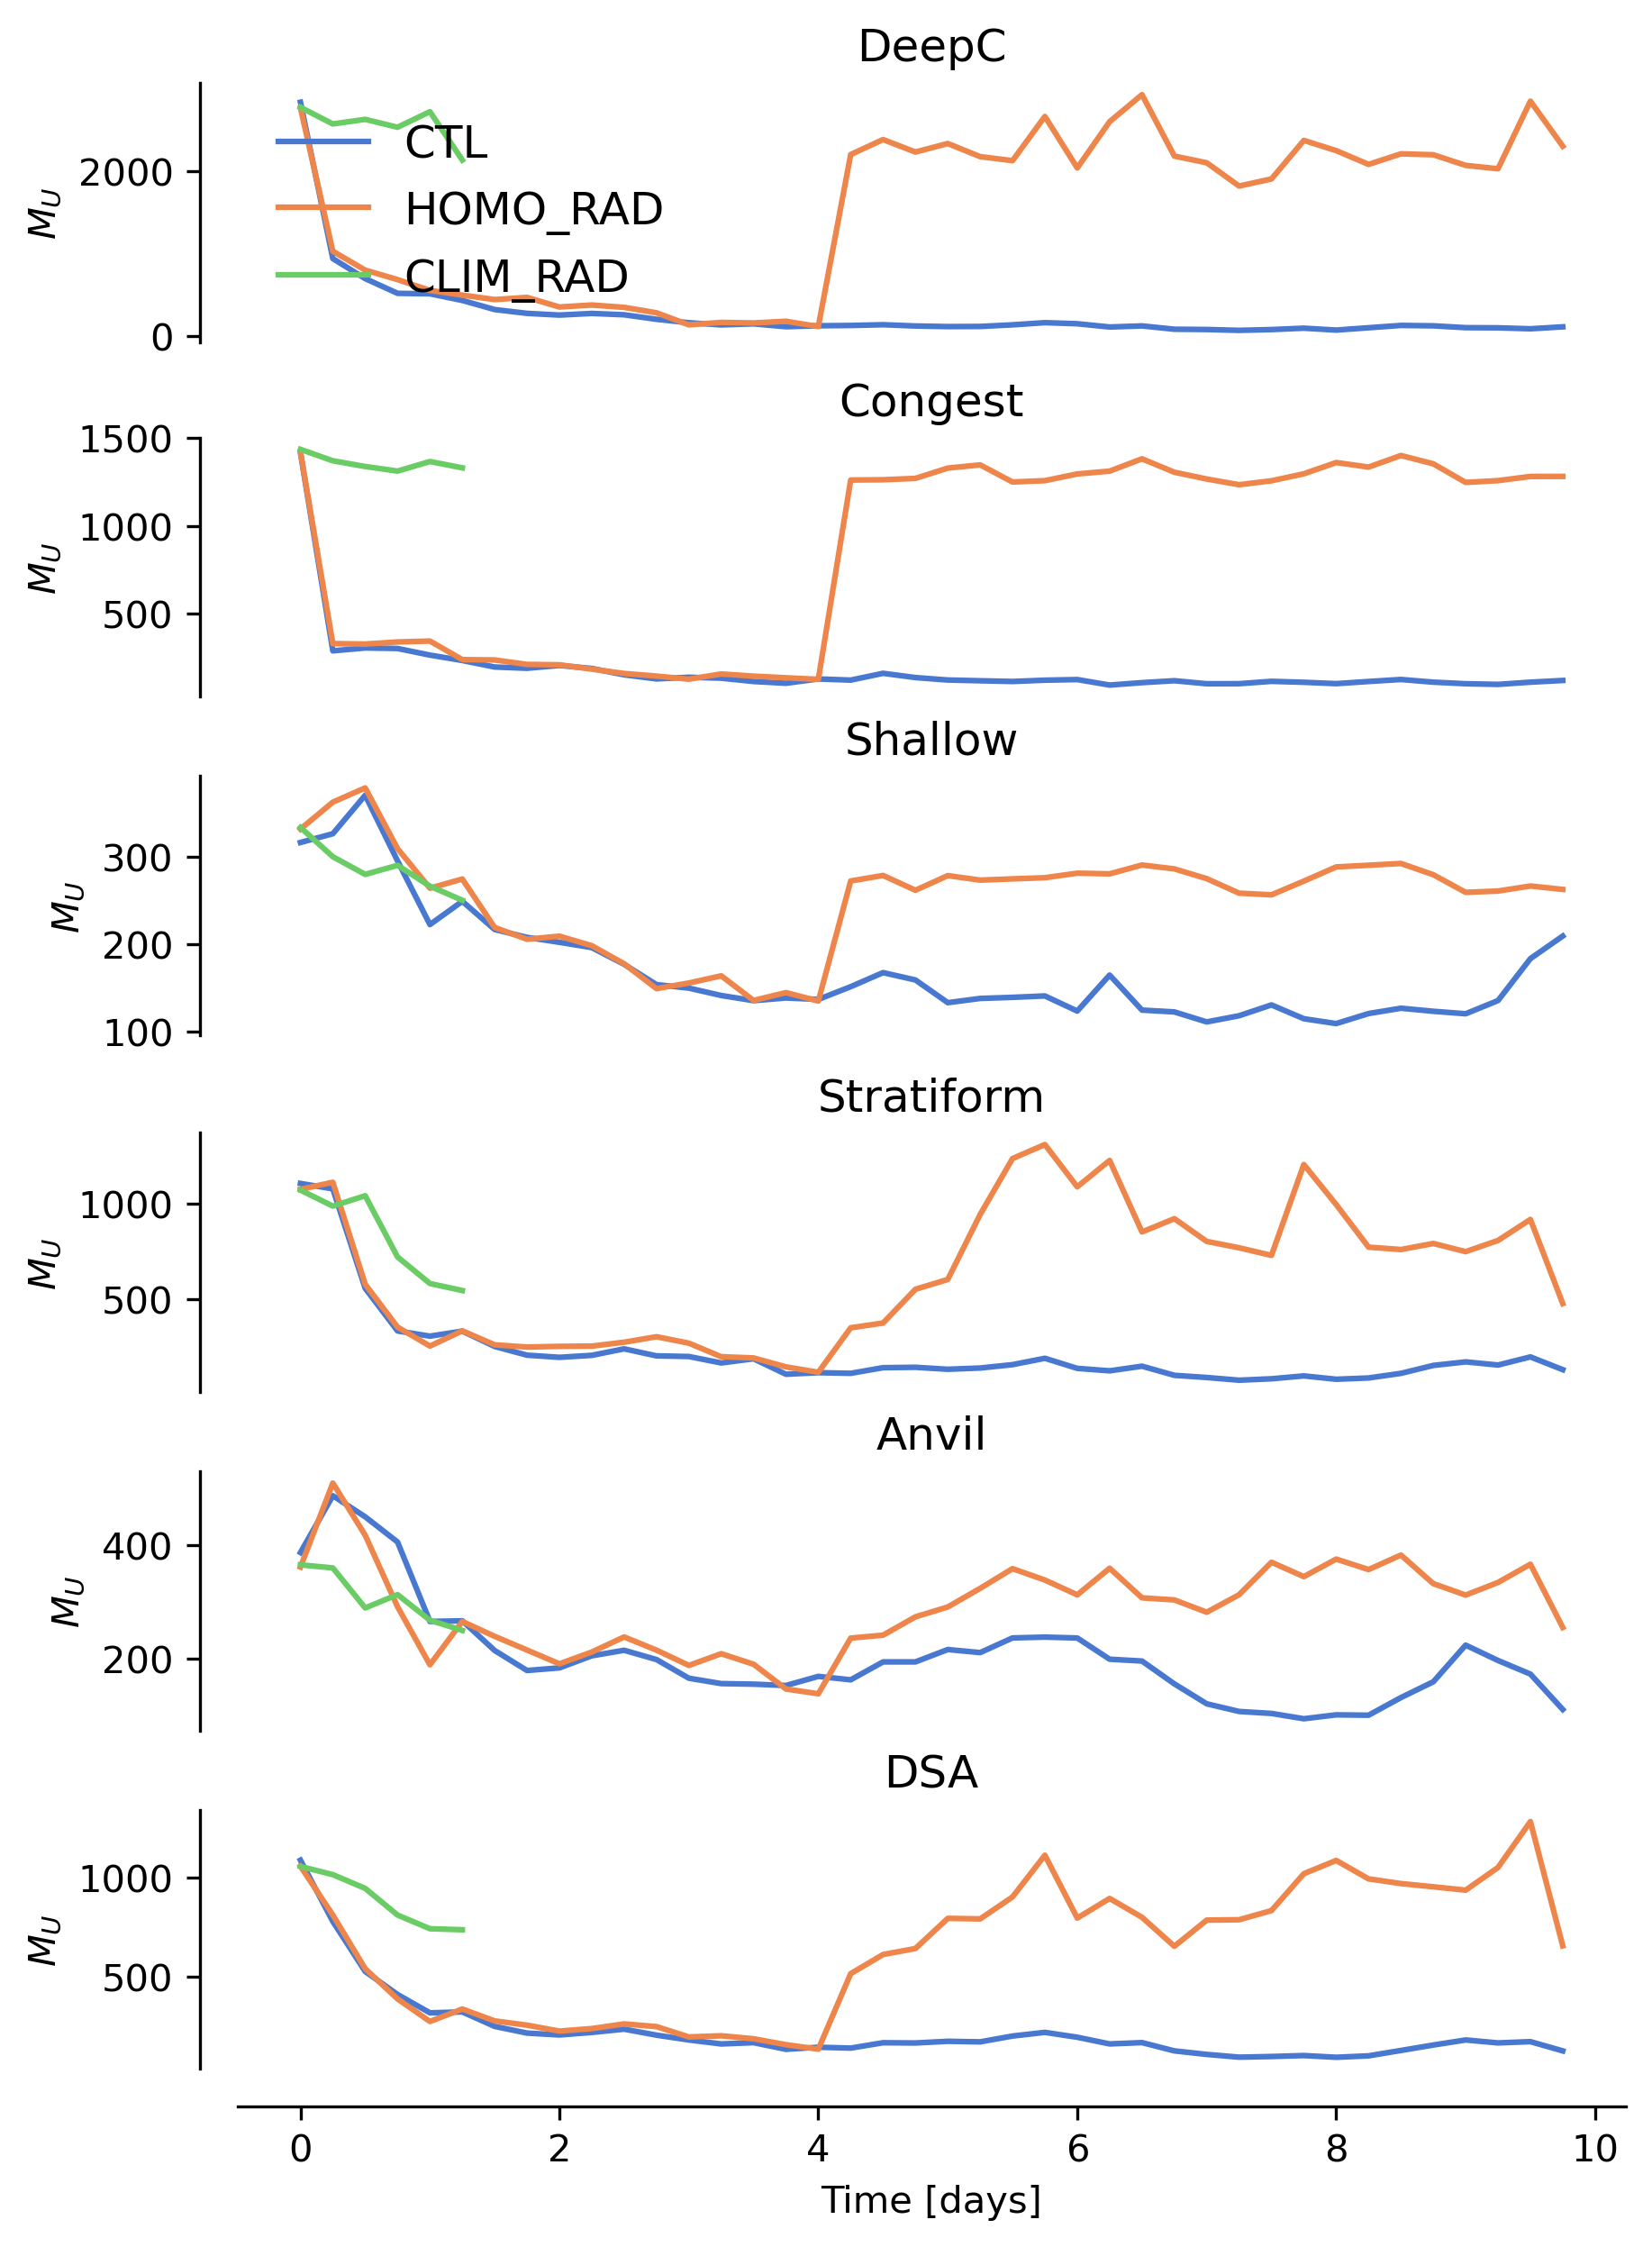

In [164]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('$M_U$')

    for iexp in range(ntest):
        tser = mu[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

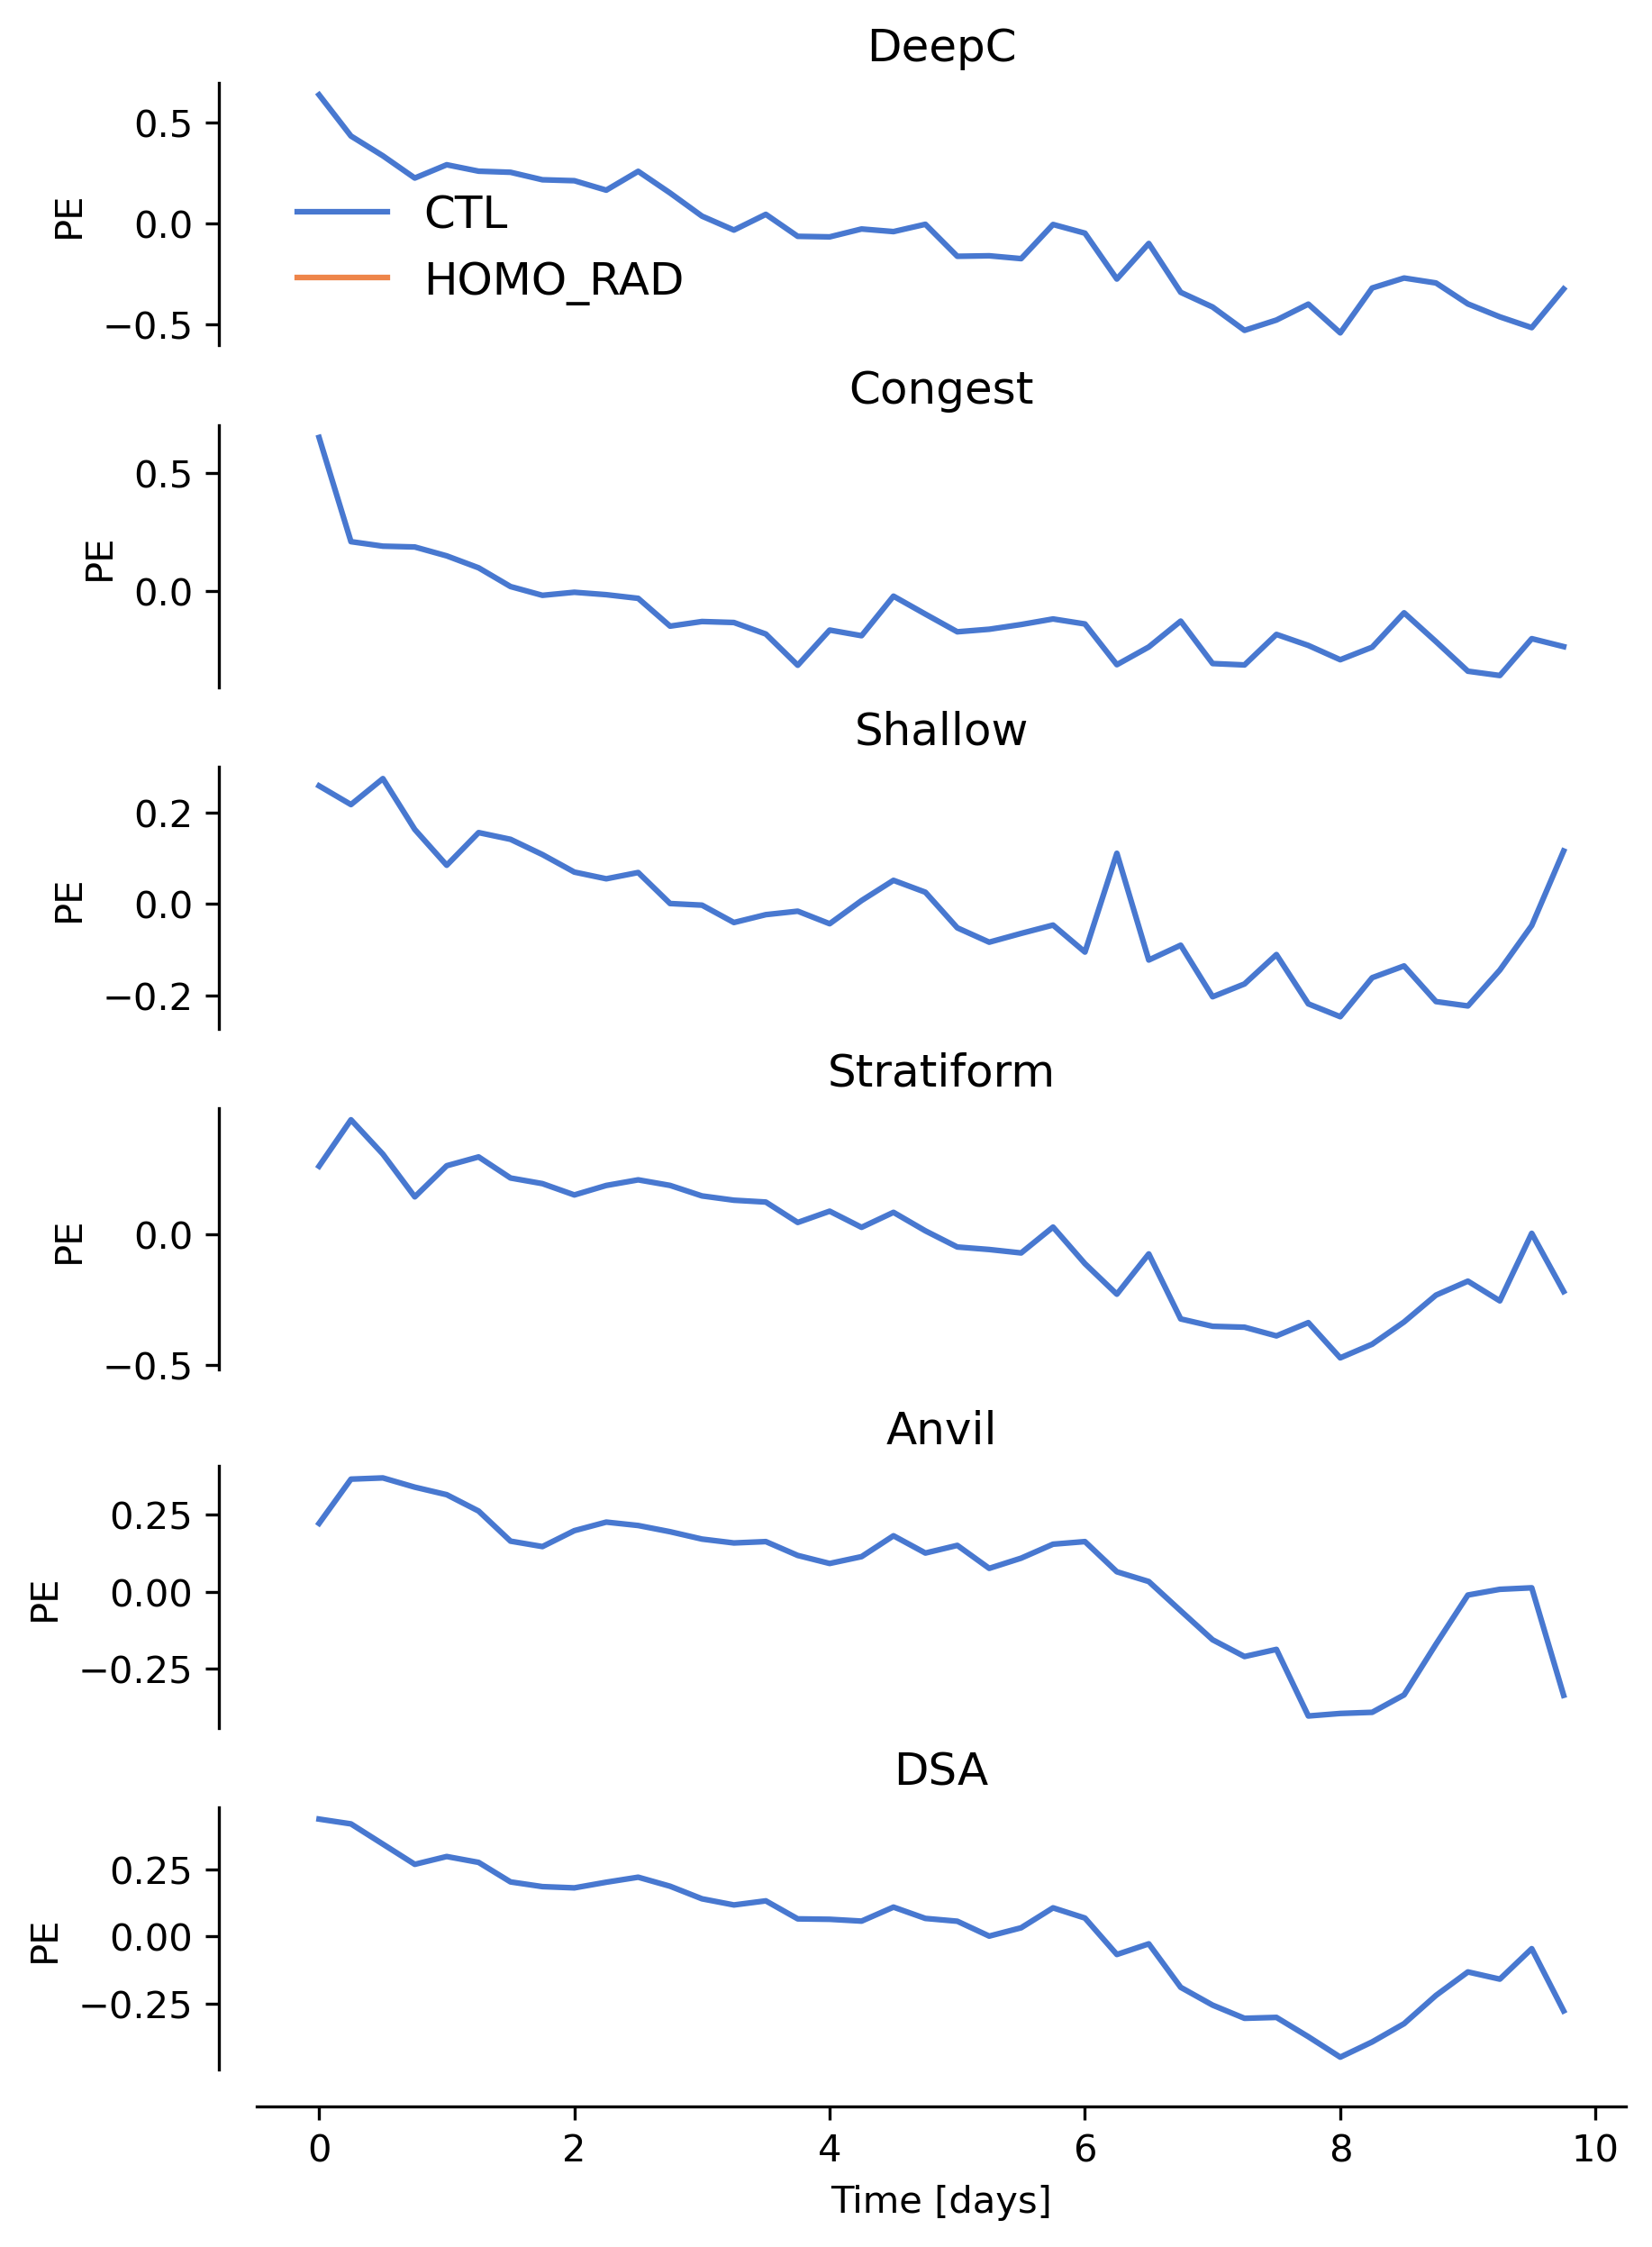

In [ ]:
# create figure
fig_x = 6
fig_y = 1.2*nclass + 1
fig, axs = plt.subplots(nclass,1, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

for iclass, iax in enumerate(axs):

    iax.set_title(pclass_names_long[iclass])
    iax.set_ylabel('PE')

    for iexp in range(ntest):
        tser = (1 - (-md/mu))[iexp,iclass,:]
        iax.plot(times, tser, linewidth=1.5, label=test_names[iexp])
        # ivar_smooth, confidence_interval, nwindow = running_mean_conf(pltvar)
        # x_smoothed = times[nwindow//2:-nwindow//2+1]
        # axs.plot(x_smoothed, ivar_smooth, linewidth=1.5, label=test_names[itest])
        # axs.fill_between(x_smoothed,
        #     ivar_smooth - confidence_interval,
        #     ivar_smooth + confidence_interval,
        #     alpha=0.4,label="95% CI")

sns.despine(offset=10,ax=axs[-1])
for iaxs in axs[:-1]:
    sns.despine(offset=10,ax=iaxs, bottom=True)
    # Remove x-ticks
    iaxs.set_xticks([])

axs[-1].set_xlabel('Time [days]')
axs[0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()

#### Boxplots

/glade/derecho/scratch/ruppert/tmp/ipykernel_35275/2728267168.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  iax.set_xticklabels(['C', 'H'])
/glade/derecho/scratch/ruppert/tmp/ipykernel_35275/2728267168.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  iax.set_xticklabels(['C', 'H'])
/glade/derecho/scratch/ruppert/tmp/ipykernel_35275/2728267168.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  iax.set_xticklabels(['C', 'H'])
/glade/derecho/scratch/ruppert/tmp/ipykernel_35275/2728267168.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  iax.set_xticklabels(['C', 'H'])
/glade/derecho/scratch/ruppert/tmp/ipykernel_35275/2728267168.py:16: UserWar

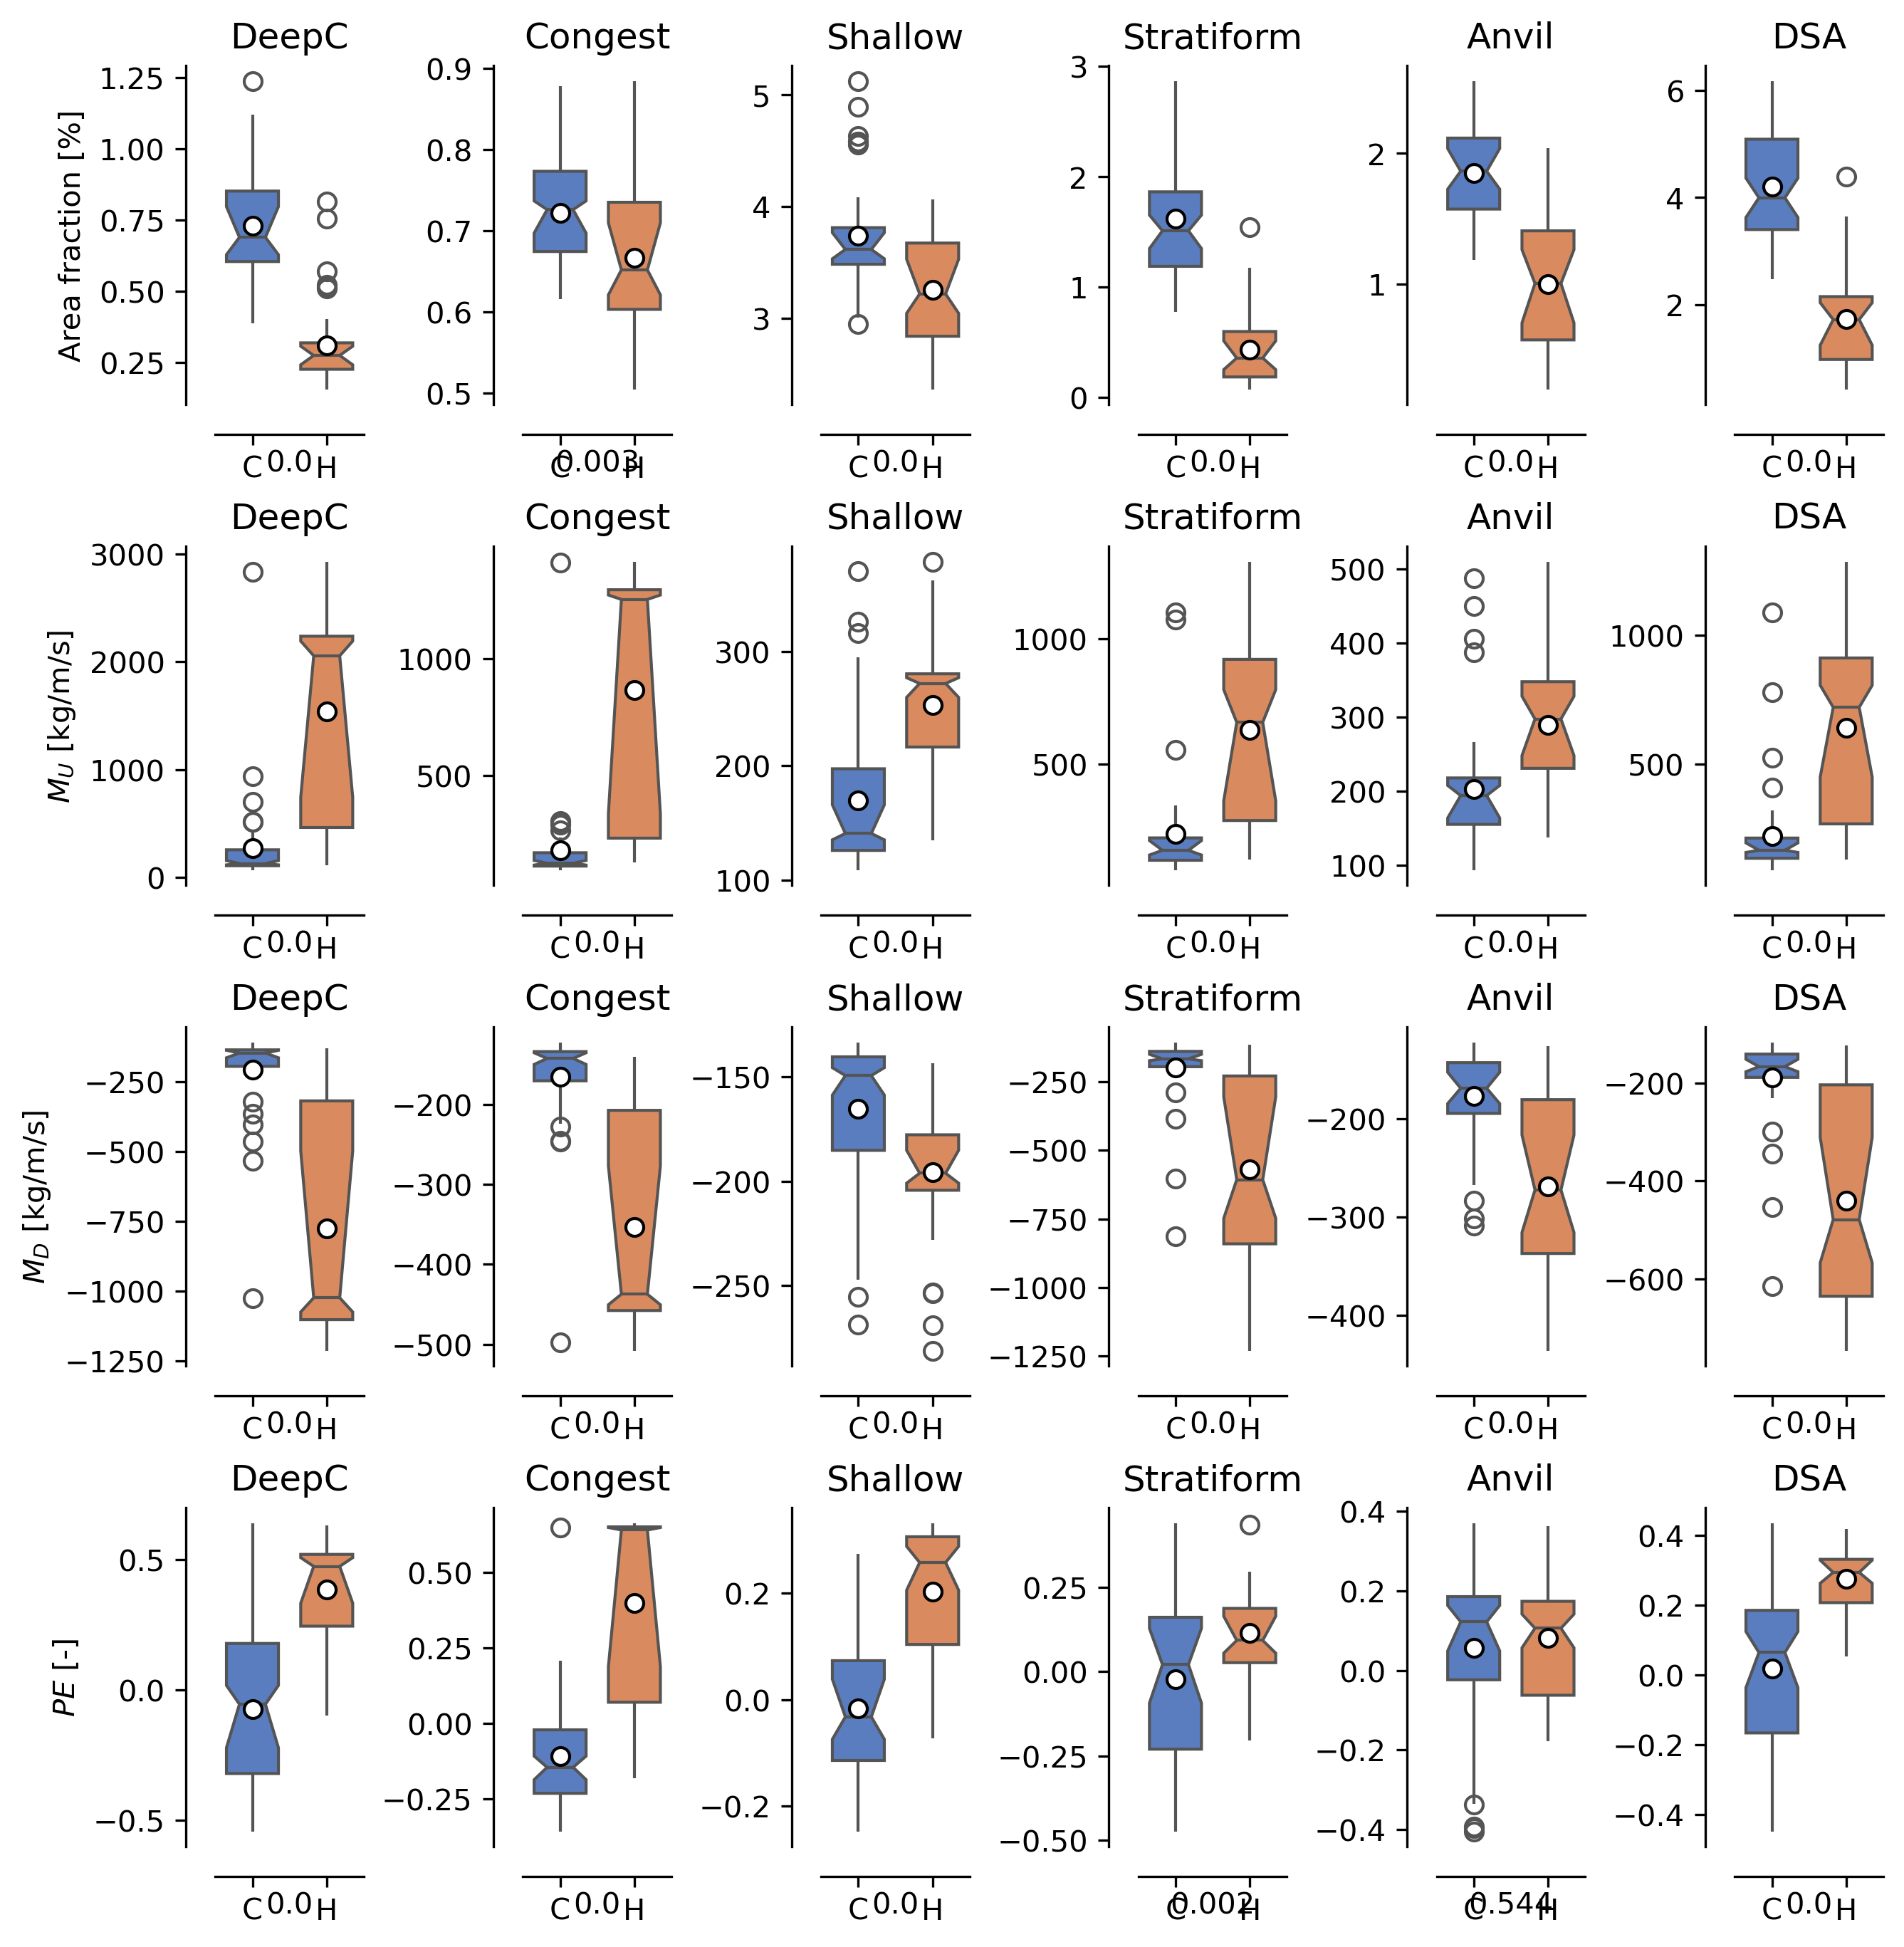

In [112]:
from scipy.stats import ttest_ind

def plot_boxplots(pltvar, axs, ntest, it_max, ytitle):
      axs[0].set_ylabel(ytitle)
      for iclass, iax in enumerate(axs):
            iax.set_title(pclass_names_long[iclass])
            colors = sns.color_palette()[:2]
            sns.boxplot([pltvar[iexp,iclass,:it_max] for iexp in range(ntest)],
                        width=0.7, showmeans=True,
                        meanprops={"marker":"o", "markerfacecolor":"white",
                              "markeredgecolor":"black", "markersize":"6"},
                        palette=colors,
                        ax=iax, notch=True, showcaps=False, bootstrap=10000,
                        showfliers=True,)
            iax.set_xticklabels(['C', 'H'])

            # Add t-test
            t_stat, p_value = ttest_ind(pltvar[0,iclass,:it_max],
                                    pltvar[1,iclass,:it_max],
                                    equal_var=True)
            iax.text(0.5, -0.13, str(np.round(p_value, 3)),
                  ha='center', va='top', transform=iax.transAxes)#, fontsize=10)
      return None

t_max = 5
it_max = t_max*4
it_max = len(times)

# create figure
fig_x = 1.3*nclass + 1
fig_y = 9
fig, axs = plt.subplots(4,nclass, figsize=(fig_x,fig_y), layout="constrained", dpi=300)
sns.set_palette('muted')

it_max = np.max(np.where(~np.isnan(pclass_frac[1,0,:]))[0]) + 1

# PClass Area
pltvar = pclass_frac
ytitle = 'Area fraction [%]'
plot_boxplots(pltvar, axs.flatten()[0:nclass], ntest, it_max, ytitle)

# M_U
pltvar = mu
ytitle = '$M_U$ [kg/m/s]'
plot_boxplots(pltvar, axs.flatten()[nclass:nclass*2], ntest, it_max, ytitle)

# M_D
pltvar = md
ytitle = '$M_D$ [kg/m/s]'
plot_boxplots(pltvar, axs.flatten()[nclass*2:nclass*3], ntest, it_max, ytitle)

# M_D
pltvar = 1 - (-md/mu)
ytitle = '$PE$ [-]'
plot_boxplots(pltvar, axs.flatten()[nclass*3:nclass*4], ntest, it_max, ytitle)

for iaxs in axs.flatten():
      sns.despine(offset=10,ax=iaxs, top=True, right=True)
#     sns.despine(offset=10,ax=iaxs, bottom=True)
#     # Remove x-ticks
#     iaxs.set_xticks([])

# axs[-1].set_xlabel('Time [days]')
axs[0,0].legend(loc="lower left", frameon=False, fontsize=12)#, bbox_to_anchor=(0.05, 0.05))
plt.show()